## Mushroom Image classification with Convolutional Neural Networks

For Raspberry Pi - Model to identify chanterelles from other mushrooms

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *

In [3]:
path = Path("/home/filip/Mushrooms")
sz=224
path.ls()

[PosixPath('/home/filip/Mushrooms/Image recognition chanterelles - prediction only.ipynb'),
 PosixPath('/home/filip/Mushrooms/models'),
 PosixPath('/home/filip/Mushrooms/test'),
 PosixPath('/home/filip/Mushrooms/.ipynb_checkpoints'),
 PosixPath('/home/filip/Mushrooms/train'),
 PosixPath('/home/filip/Mushrooms/Mushrooms.zip')]

In [4]:
path_train = path / 'train'


It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [2]:
[torch.cuda.is_available(), torch.backends.cudnn.enabled]

[True, True]

In [5]:
bs = 200
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
num_workers = 5

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.



In [11]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [56]:
learn=None
gc.collect()
torch.cuda.empty_cache()

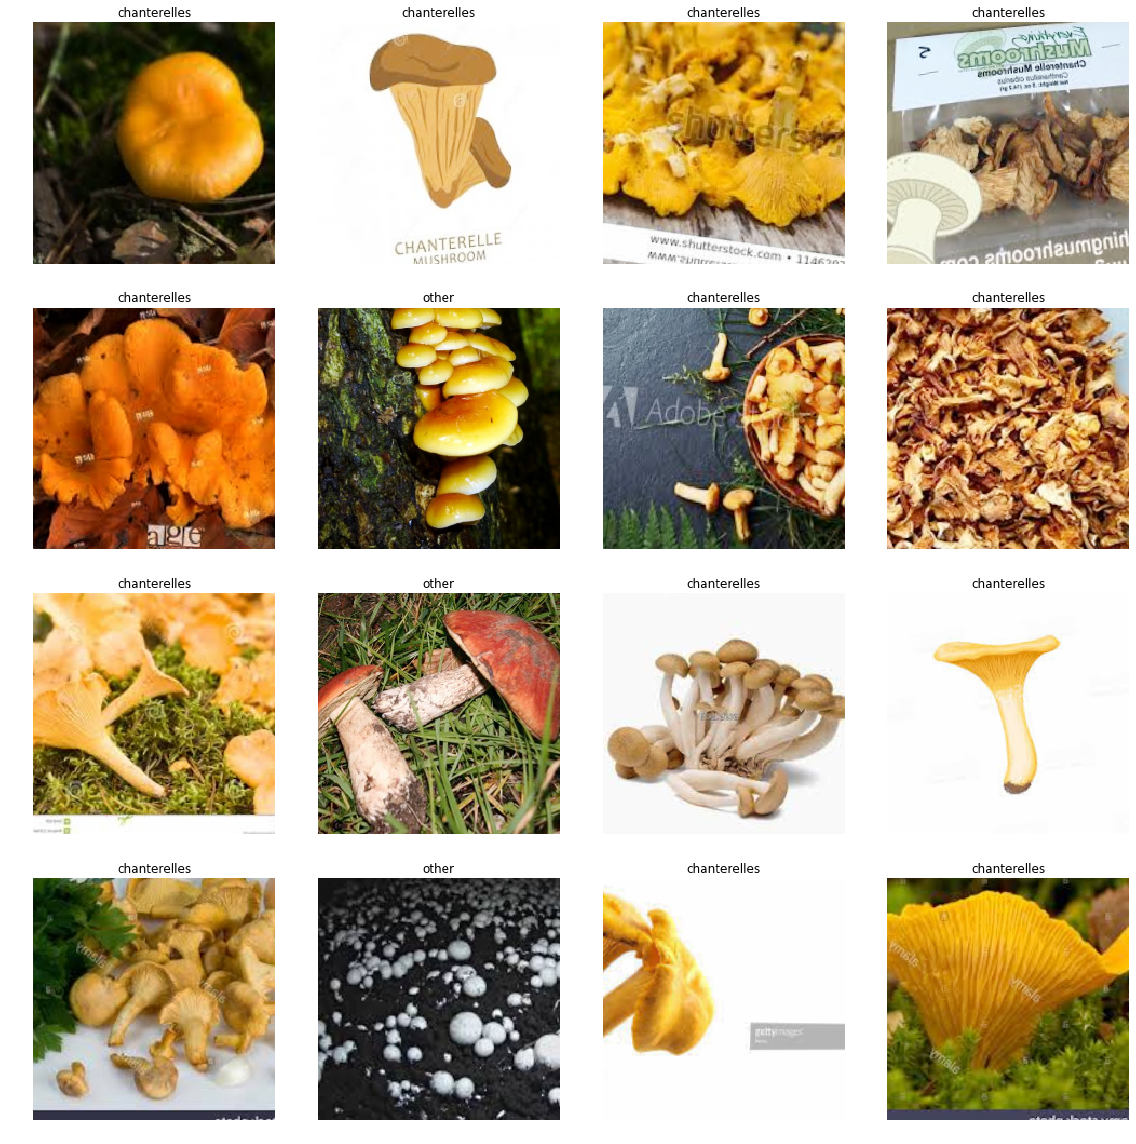

In [57]:
#fastai v1.0
np.random.seed(42)
data = ImageDataBunch.from_folder(path_train,ds_tfms=get_transforms(),valid_pct=0.2,
                                  size=224, bs=bs, num_workers=num_workers, test="test").normalize(imagenet_stats)
data.show_batch(rows=4)



In [64]:
#fastai v1.0
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()

In [65]:
learn.freeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.682933,0.317321,0.888446,00:04
1,0.499513,0.251951,0.908367,00:04
2,0.412867,0.261175,0.912351,00:04
3,0.349172,0.261497,0.916335,00:04
4,0.302862,0.231125,0.916335,00:04
5,0.271418,0.210127,0.924303,00:04
6,0.249989,0.203926,0.936255,00:04
7,0.229127,0.194635,0.940239,00:04
8,0.213700,0.193452,0.940239,00:04
9,0.197641,0.192852,0.940239,00:04


In [66]:
learn.save('mushroom-res34-stage-1')

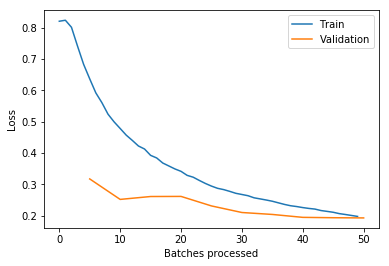

In [67]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


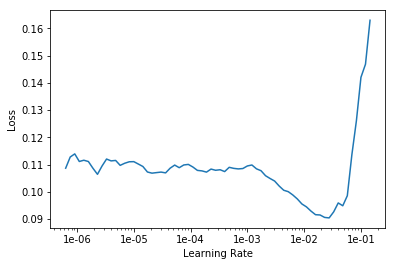

In [68]:
learn.lr_find()
learn.recorder.plot()

In [69]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.119592,0.200957,0.932271,00:05
1,0.113197,0.195901,0.936255,00:04
2,0.102397,0.189864,0.936255,00:05
3,0.097863,0.183338,0.936255,00:04
4,0.091741,0.194711,0.936255,00:04
5,0.084025,0.207382,0.940239,00:05
6,0.074949,0.209052,0.936255,00:04
7,0.069666,0.212154,0.932271,00:04
8,0.063436,0.215418,0.928287,00:04
9,0.057003,0.223080,0.932271,00:04


In [70]:
learn.save('mushroom-res34-stage-2')

In [80]:
learn.export()

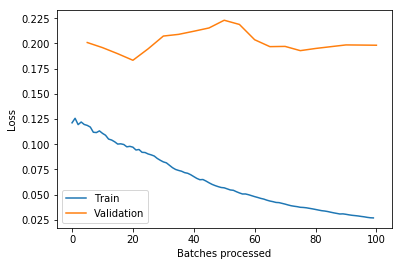

In [71]:
learn.recorder.plot_losses()

In [72]:
learn.to_fp32();

In [73]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()


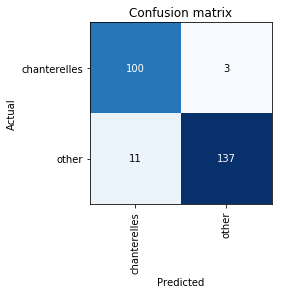

In [79]:
interp.plot_confusion_matrix()

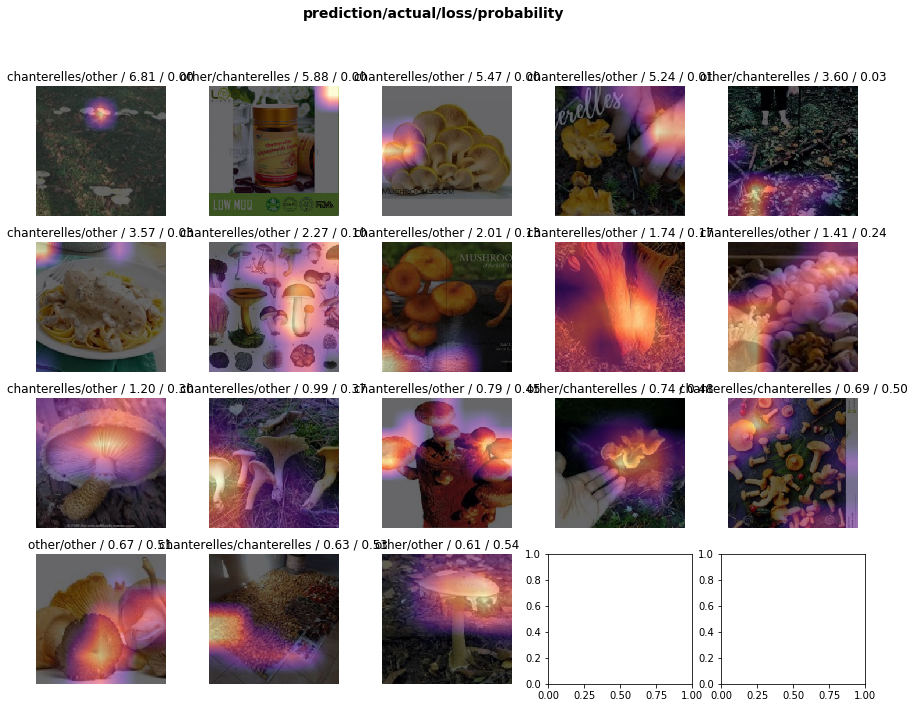

In [74]:
interp.plot_top_losses(18, figsize=(15,11))

In [75]:
learn.to_fp16();

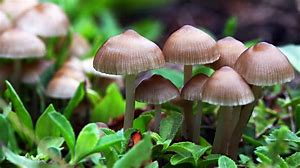

In [6]:
img = open_image(path/'test'/'image-4x5.jpeg')
img

In [7]:
learn = load_learner(path_train)
learn.to_fp32();

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute 

In [9]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class


Category other

In [43]:
from picamera import PiCamera
from time import sleep



In [44]:
camera=PiCamera()
camera.resolution = (1024,768)

In [69]:
camera.capture('/home/filip/Mushrooms/temp.jpg',resize=(224,224))
img = open_image('/home/filip/Mushrooms/temp.jpg')
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,outputs)


other tensor([7.4559e-04, 9.9925e-01])


In [55]:
camera.close()

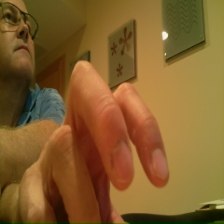

In [67]:
img

In [51]:
from io import BytesIO
from PIL import Image

In [56]:
stream = BytesIO()
camera = PiCamera()

In [63]:

camera.capture(stream,format='jpeg',resize=(224,224))
stream.seek(0)
#img=Image.open(stream)
img=open_image(stream)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category chanterelles